# 1. Import Required Libraries

In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 2. Load Dataset

In [3]:
dataset = pd.read_csv("../data/interim/demand_forecast.csv", 
parse_dates=["order_date"])

# 3. Quick EDA

## 3.1. Metadata Checking

In [4]:
dataset.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021284 entries, 0 to 1021283
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   order_id             1021284 non-null  int64         
 1   product_id           1021284 non-null  object        
 2   product_description  1021284 non-null  object        
 3   quantity             1021284 non-null  int64         
 4   order_date           1021284 non-null  datetime64[ns]
 5   unit_price           1021284 non-null  float64       
 6   customer_id          794117 non-null   float64       
 7   country              1021284 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 62.3+ MB


## 3.2. Exploratory Data Analysis

In [6]:
# cek banyaknya transaksi per order_date
dataset.groupby("order_date").size()

order_date
2009-12-01 07:45:00     8
2009-12-01 07:46:00     4
2009-12-01 09:06:00    19
2009-12-01 09:08:00    23
2009-12-01 09:24:00    17
                       ..
2011-12-09 12:23:00     2
2011-12-09 12:25:00     2
2011-12-09 12:31:00    21
2011-12-09 12:49:00     4
2011-12-09 12:50:00    15
Length: 43157, dtype: int64

In [7]:
dataset = dataset.set_index("order_date")

In [8]:
dataset.head()

,order_id,product_id,product_description,quantity,unit_price,customer_id,country
order_date,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom


In [9]:
# buat 3 buah dataset sekaligus jika nantinya dibutuhkan

# dataset monthly
dataset_monthly = dataset.groupby("product_id")["quantity"].resample("ME") \
    .sum().reset_index().sort_values(by=["product_id", "order_date"])

# dataset weekly
dataset_weekly = dataset.groupby("product_id")["quantity"].resample("W") \
    .sum().reset_index().sort_values(by=["product_id", "order_date"])

# dataset daily
dataset_daily = dataset.groupby("product_id")["quantity"].resample("D") \
    .sum().reset_index().sort_values(by=["product_id", "order_date"])

In [10]:
dataset_monthly.head()

,product_id,order_date,quantity
0,10002,2009-12-31,215
1,10002,2010-01-31,291
2,10002,2010-02-28,257
3,10002,2010-03-31,641
4,10002,2010-04-30,1332


In [11]:
dataset_weekly.head()

,product_id,order_date,quantity
0,10002,2009-12-06,140
1,10002,2009-12-13,24
2,10002,2009-12-20,37
3,10002,2009-12-27,14
4,10002,2010-01-03,0


In [12]:
dataset_daily.head(10)

,product_id,order_date,quantity
0,10002,2009-12-01,12
1,10002,2009-12-02,0
2,10002,2009-12-03,6
3,10002,2009-12-04,73
4,10002,2009-12-05,0
5,10002,2009-12-06,49
6,10002,2009-12-07,2
7,10002,2009-12-08,12
8,10002,2009-12-09,0
9,10002,2009-12-10,1


Text(0, 0.5, 'Quantity')

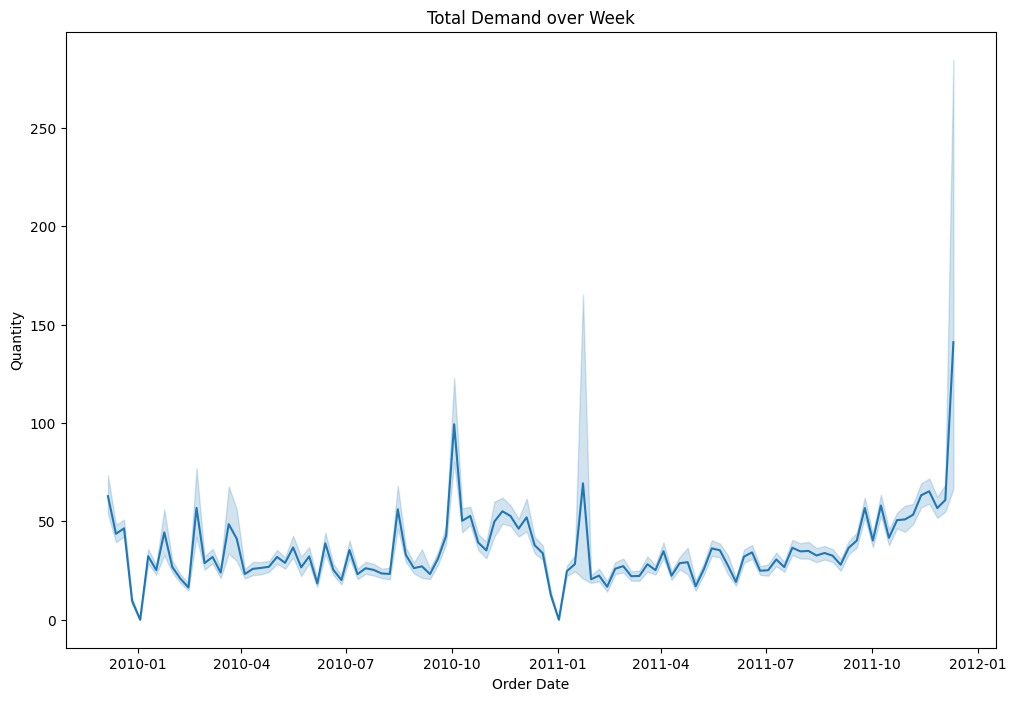

In [13]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=dataset_weekly, x="order_date", y="quantity")
ax.set_title("Total Demand over Week")
ax.set_xlabel("Order Date")
ax.set_ylabel("Quantity")

Text(0, 0.5, 'Quantity')

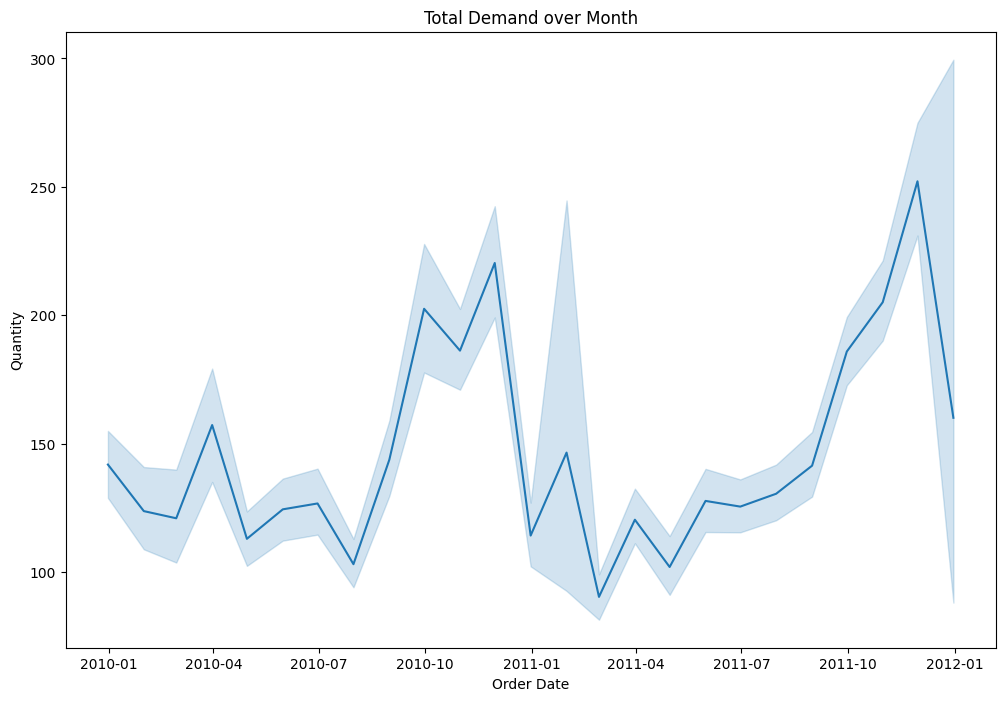

In [14]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=dataset_monthly, x="order_date", y="quantity")
ax.set_title("Total Demand over Month")
ax.set_xlabel("Order Date")
ax.set_ylabel("Quantity")

In [15]:
# perhitungan slope pada data weekly
y_weekly = dataset_weekly.quantity.values
X_weekly = np.arange(len(y_weekly)).reshape(-1, 1)
model_weekly = LinearRegression()
model_weekly.fit(X_weekly, y_weekly)
model_weekly.coef_[0]

np.float64(-0.00010461402464153592)

In [16]:
# perhitungan slope pada data monthly
y_monthly = dataset_monthly.quantity.values
X_monthly = np.arange(len(y_monthly)).reshape(-1, 1)
model_monthly = LinearRegression()
model_monthly.fit(X_monthly, y_monthly)
model_monthly.coef_[0]

np.float64(-0.0018586646689174532)

In [17]:
# hitung r-squared untuk weekly
y_pred = model_weekly.predict(X_weekly)
r2 = r2_score(y_weekly, y_pred)
r2

0.0005872016597485707

In [18]:
# hitung r-squared untuk monthly
y_pred = model_weekly.predict(X_monthly)
r2 = r2_score(y_monthly, y_pred)
r2

-0.011865868161512916

Text(0, 0.5, 'Quantity')

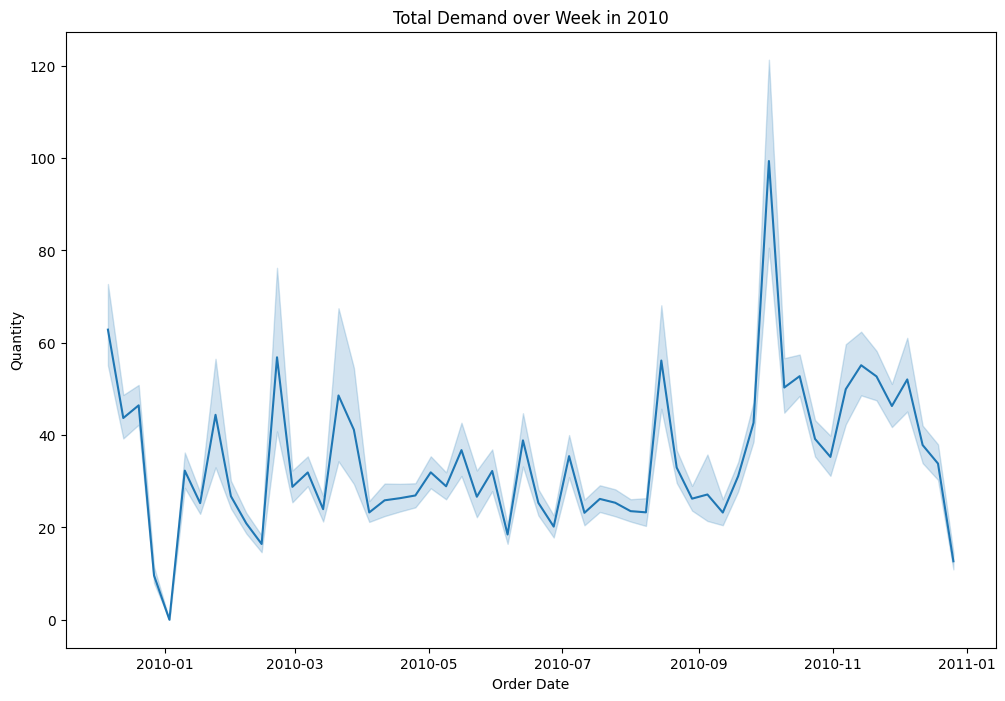

In [19]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=dataset_weekly[dataset_weekly.order_date<"2011-01-01"],
x="order_date", y="quantity")
ax.set_title("Total Demand over Week in 2010")
ax.set_xlabel("Order Date")
ax.set_ylabel("Quantity")

Text(0, 0.5, 'Quantity')

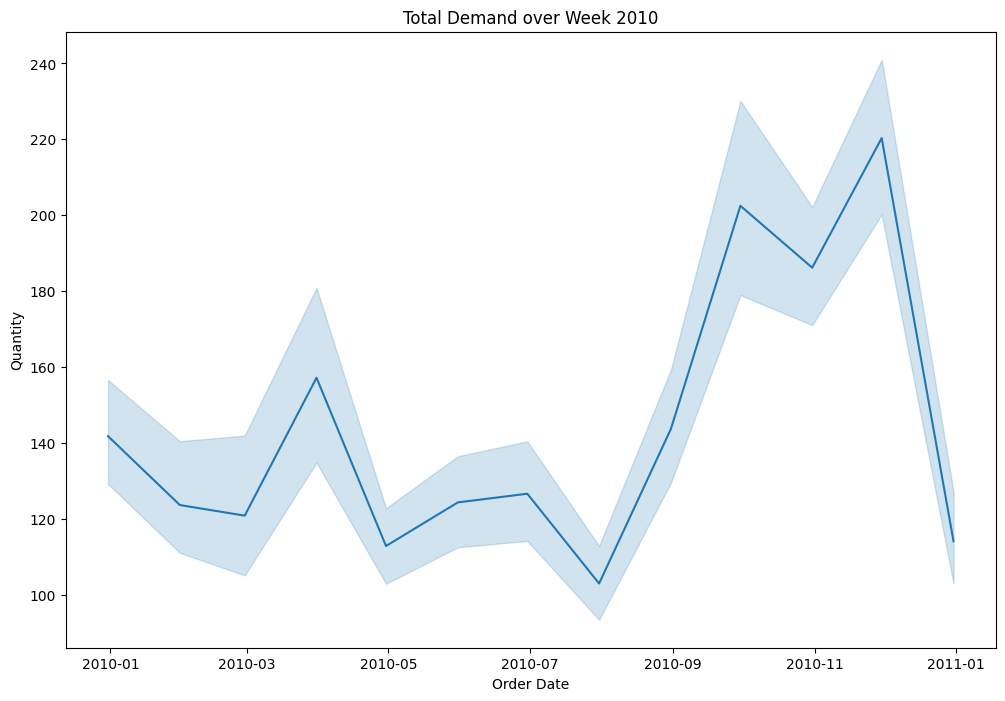

In [20]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=dataset_monthly[dataset_monthly.order_date<"2011-01-01"],
x="order_date", y="quantity")
ax.set_title("Total Demand over Week 2010")
ax.set_xlabel("Order Date")
ax.set_ylabel("Quantity")

In [21]:
# perhitungan slope pada data weekly 2010
y_weekly = dataset_weekly[dataset_weekly.order_date<"2011-01-01"].quantity\
    .values
X_weekly = np.arange(len(y_weekly)).reshape(-1, 1)
model_weekly = LinearRegression()
model_weekly.fit(X_weekly, y_weekly)
model_weekly.coef_[0]

np.float64(-0.0002240255987757921)

In [22]:
# perhitungan slope pada data monthly 2010
y_weekly = dataset_monthly[dataset_monthly.order_date<"2011-01-01"].quantity\
    .values
X_weekly = np.arange(len(y_weekly)).reshape(-1, 1)
model_weekly = LinearRegression()
model_weekly.fit(X_weekly, y_weekly)
model_weekly.coef_[0]

np.float64(-0.004026637762129831)

In [23]:
# hitung r-squared untuk weekly 2010
y_pred = model_weekly.predict(X_weekly)
r2 = r2_score(y_weekly, y_pred)
r2

0.010420228052119729

In [24]:
# hitung r-squared untuk monthly 2010
y_pred = model_monthly.predict(X_monthly)
r2 = r2_score(y_monthly, y_pred)
r2

0.0022946625078642535

Text(0, 0.5, 'Quantity')

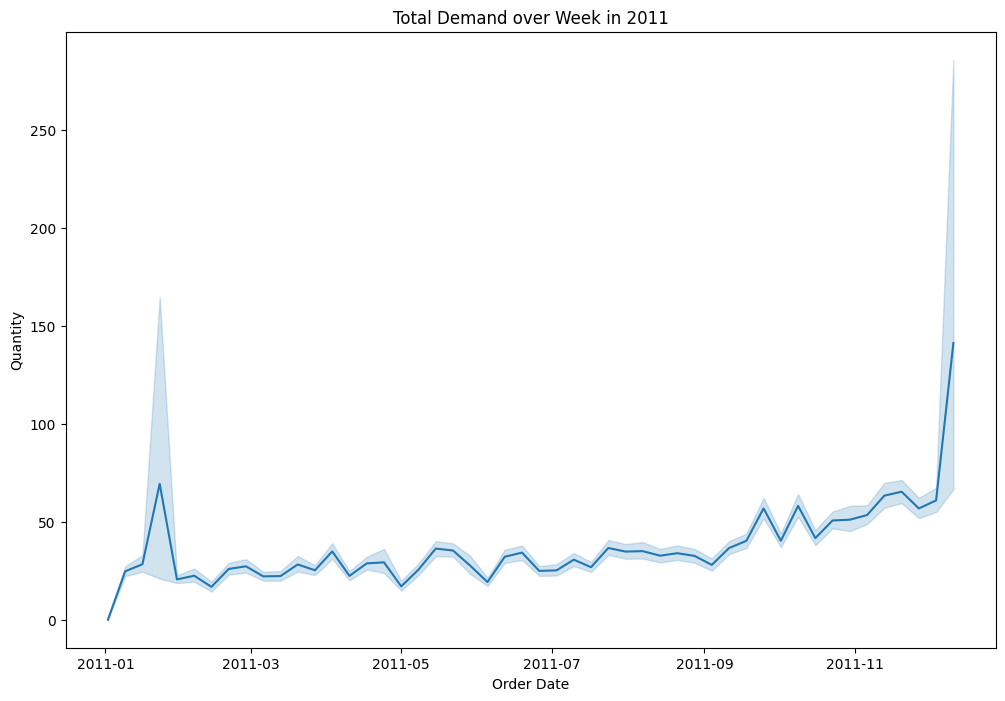

In [25]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=dataset_weekly[dataset_weekly.order_date>="2011-01-01"],
x="order_date", y="quantity")
ax.set_title("Total Demand over Week in 2011")
ax.set_xlabel("Order Date")
ax.set_ylabel("Quantity")

Text(0, 0.5, 'Quantity')

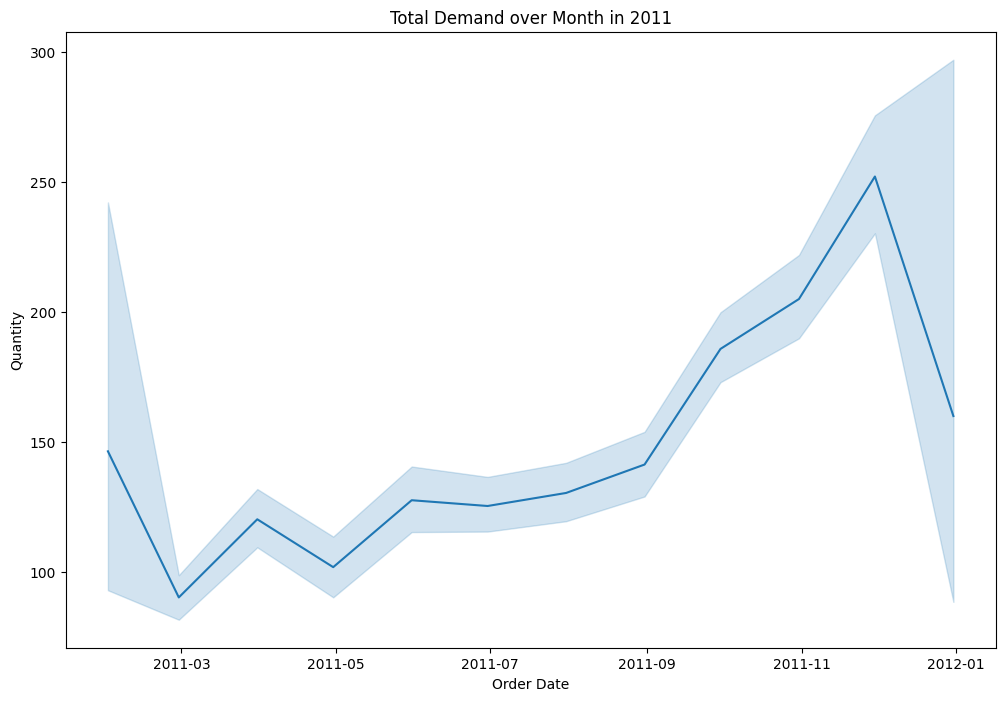

In [26]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=dataset_monthly[dataset_monthly.order_date>="2011-01-01"],
x="order_date", y="quantity")
ax.set_title("Total Demand over Month in 2011")
ax.set_xlabel("Order Date")
ax.set_ylabel("Quantity")

In [27]:
# perhitungan slope pada data weekly 2011
y_weekly = dataset_weekly[dataset_weekly.order_date>="2011-01-01"].quantity\
    .values
X_weekly = np.arange(len(y_weekly)).reshape(-1, 1)
model_weekly = LinearRegression()
model_weekly.fit(X_weekly, y_weekly)
model_weekly.coef_[0]

np.float64(-0.00015291463865491038)

In [28]:
# perhitungan slope pada data monthly 2011
y_monthly = dataset_monthly[dataset_monthly.order_date>="2011-01-01"].quantity\
    .values
X_monthly = np.arange(len(y_monthly)).reshape(-1, 1)
model_monthly = LinearRegression()
model_monthly.fit(X_monthly, y_monthly)
model_monthly.coef_[0]

np.float64(-0.0027100198924177995)

In [29]:
# hitung r-squared untuk weekly 2011
y_pred = model_weekly.predict(X_weekly)
r2 = r2_score(y_weekly, y_pred)
r2

0.00013710786993514912

In [30]:
# hitung r-squared untuk monthly 2011
y_pred = model_monthly.predict(X_monthly)
r2 = r2_score(y_monthly, y_pred)
r2

0.0005744264244803565

In [31]:
dataset_monthly["month"] = dataset_monthly["order_date"].dt.month
overall_mean = dataset_monthly["quantity"].mean()

seasonal_index_monthly = dataset_monthly.groupby("month")["quantity"].mean()\
    /overall_mean

Text(0, 0.5, 'Ratio')

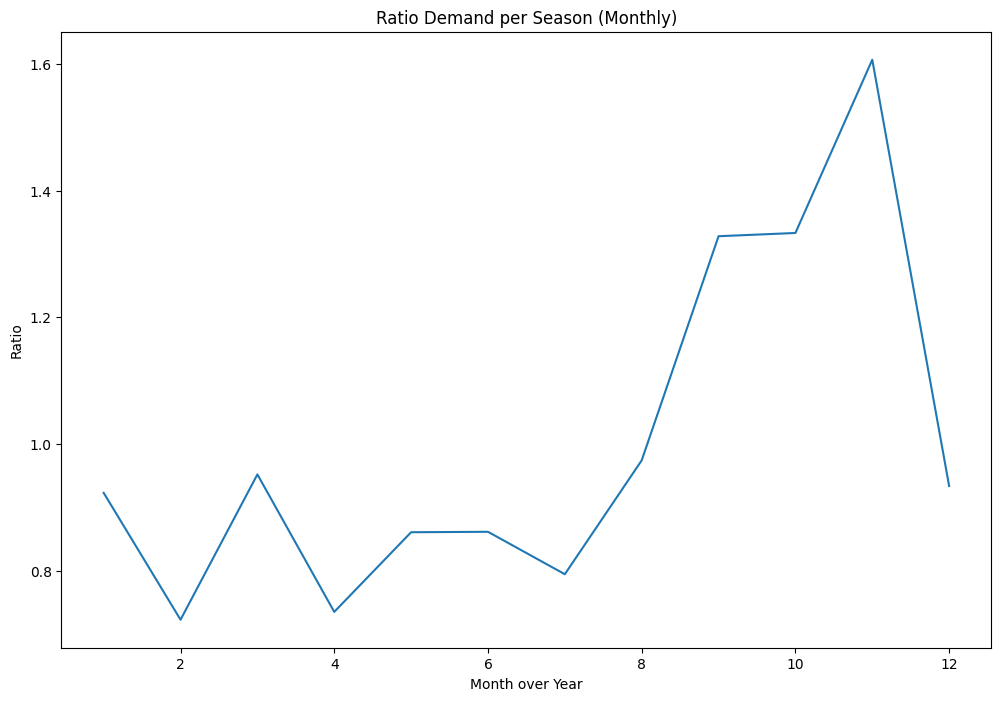

In [32]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=seasonal_index_monthly)
ax.set_title("Ratio Demand per Season (Monthly)")
ax.set_xlabel("Month over Year")
ax.set_ylabel("Ratio")

In [35]:
# drop kolom yang tidak perlu
dataset_monthly = dataset_monthly.drop(columns=["month"])

In [36]:
# lakukan group by per product_id dan liat demandnya (sum of quantity)
sku_demand = dataset_monthly.groupby("product_id")["quantity"].sum()\
    .sort_values(ascending=False)

Text(0, 0.5, 'Count')

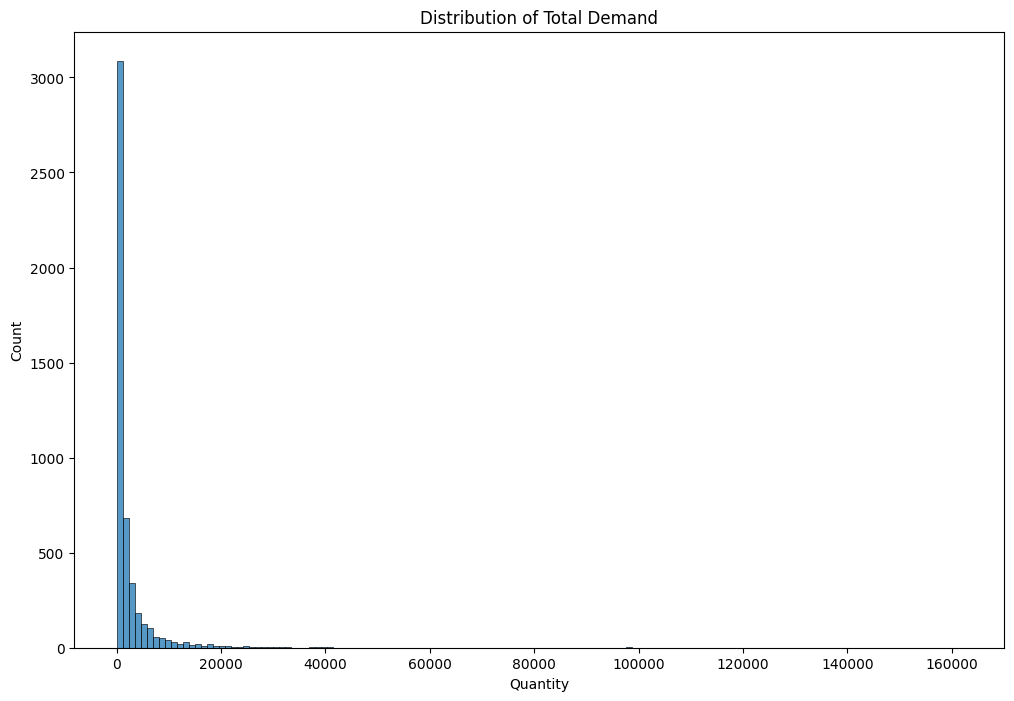

In [37]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(sku_demand)
ax.set_title("Distribution of Total Demand")
ax.set_xlabel("Quantity")
ax.set_ylabel("Count")

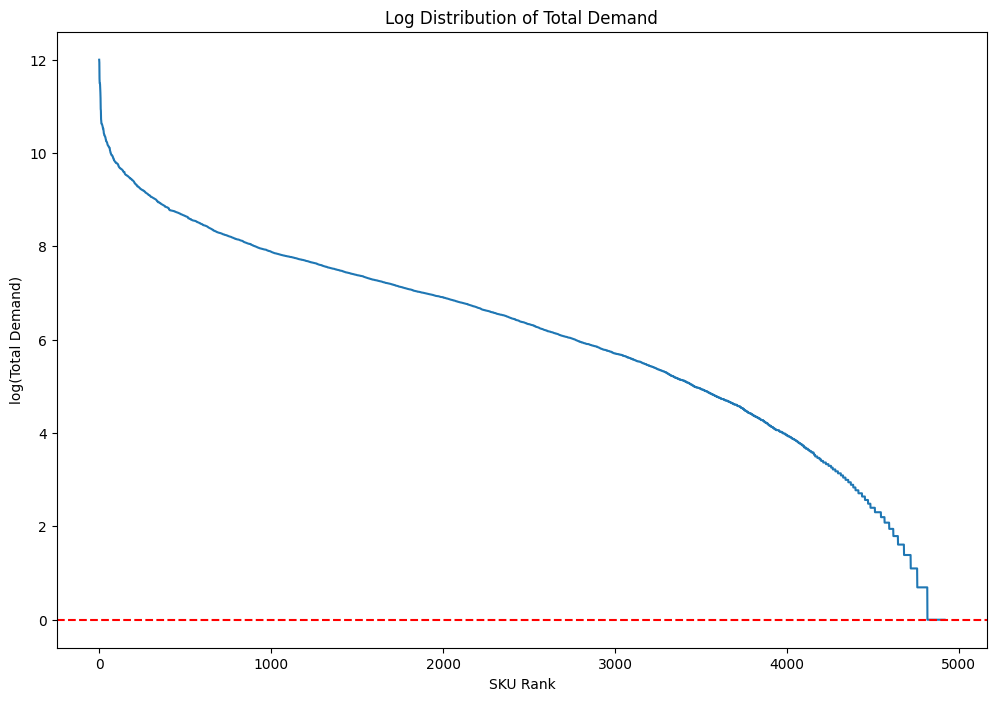

In [38]:
plt.figure(figsize=(12, 8))

# karena SKU atau product_id cukup banyak, maka seperti sebelumnya, kita bisa
# gunakan log scaling
ax = sns.lineplot(np.log(sku_demand.values))
ax.set_title("Log Distribution of Total Demand")
ax.set_xlabel("SKU Rank")
ax.set_ylabel("log(Total Demand)")
ax.axhline(color="red", ls="--")

# 4. Feature Engineering

In [39]:
# buat fitur kalender
dataset_monthly["month"] = dataset_monthly["order_date"].dt.month
dataset_monthly["week"] = dataset_monthly["order_date"].dt.isocalendar().week \
    .astype(int)
dataset_monthly["year"] = dataset_monthly["order_date"].dt.year

In [40]:
dataset_monthly

,product_id,order_date,quantity,month,week,year
0,10002,2009-12-31,215,12,53,2009
1,10002,2010-01-31,291,1,4,2010
2,10002,2010-02-28,257,2,8,2010
3,10002,2010-03-31,641,3,13,2010
4,10002,2010-04-30,1332,4,17,2010
...,...,...,...,...,...,...
79581,gift_0001_50,2011-05-31,1,5,22,2011
79582,gift_0001_50,2011-06-30,2,6,26,2011
79583,gift_0001_70,2010-06-30,1,6,26,2010
79584,gift_0001_80,2009-12-31,1,12,53,2009


In [41]:
# buat fitur lag dan rolling per product_id bukan per row seperti data satu sku
lags = [1, 7, 14, 30]
rolls = [7, 30]

for lag in lags:
    dataset_monthly[f"lag_{lag}"] = dataset_monthly.groupby("product_id")\
        ["quantity"].shift(lag)

for r in rolls:
    dataset_monthly[f"roll_mean_{r}"] = dataset_monthly.groupby("product_id")\
        ["quantity"].shift(1).rolling(r).mean()


In [42]:
dataset_monthly

,product_id,order_date,quantity,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30
0,10002,2009-12-31,215,12,53,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,10002,2010-01-31,291,1,4,2010,215.0,NaN,NaN,NaN,NaN,NaN
2,10002,2010-02-28,257,2,8,2010,291.0,NaN,NaN,NaN,NaN,NaN
3,10002,2010-03-31,641,3,13,2010,257.0,NaN,NaN,NaN,NaN,NaN
4,10002,2010-04-30,1332,4,17,2010,641.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
79581,gift_0001_50,2011-05-31,1,5,22,2011,0.0,1.0,0.0,NaN,0.285714,NaN
79582,gift_0001_50,2011-06-30,2,6,26,2011,1.0,0.0,0.0,NaN,0.285714,NaN
79583,gift_0001_70,2010-06-30,1,6,26,2010,NaN,NaN,NaN,NaN,NaN,NaN
79584,gift_0001_80,2009-12-31,1,12,53,2009,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
sku_stats = dataset_monthly.groupby("product_id").agg(total_demand=("quantity", 
"sum"), avg_demand=("quantity", "mean"), zero_ratio=("quantity", lambda x: \
    (x == 0).mean())).reset_index()

In [44]:
sku_stats

,product_id,total_demand,avg_demand,zero_ratio
0,10002,9894,582.000000,0.000000
1,10002R,4,2.000000,0.000000
2,10080,315,13.125000,0.541667
3,10109,4,4.000000,0.000000
4,10120,694,27.760000,0.160000
...,...,...,...,...
4913,gift_0001_30,24,1.090909,0.318182
4914,gift_0001_40,5,0.416667,0.583333
4915,gift_0001_50,6,0.315789,0.736842
4916,gift_0001_70,1,1.000000,0.000000


In [45]:
def sku_segment(row):
    if row["total_demand"] > sku_stats["total_demand"].quantile(0.8):
        return "FAST"
    elif row["zero_ratio"] > 0.5:
        return "INTERMITTENT"
    else:
        return "REGULAR"

In [46]:
# apply fungsi segmentasinya
sku_stats["segment"] = sku_stats.apply(sku_segment, axis=1)

In [47]:
# kita lihat hasilnya
sku_stats.segment.value_counts()

segment
REGULAR         3507
FAST             984
INTERMITTENT     427
Name: count, dtype: int64

In [48]:
# pindahkan informasi segment ke dataset dengan cara merging on product_id
dataset_monthly = dataset_monthly.merge(sku_stats[["product_id", "segment"]], \
    on="product_id", how="left")

In [49]:
dataset_monthly

,product_id,order_date,quantity,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30,segment
0,10002,2009-12-31,215,12,53,2009,NaN,NaN,NaN,NaN,NaN,NaN,FAST
1,10002,2010-01-31,291,1,4,2010,215.0,NaN,NaN,NaN,NaN,NaN,FAST
2,10002,2010-02-28,257,2,8,2010,291.0,NaN,NaN,NaN,NaN,NaN,FAST
3,10002,2010-03-31,641,3,13,2010,257.0,NaN,NaN,NaN,NaN,NaN,FAST
4,10002,2010-04-30,1332,4,17,2010,641.0,NaN,NaN,NaN,NaN,NaN,FAST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79581,gift_0001_50,2011-05-31,1,5,22,2011,0.0,1.0,0.0,NaN,0.285714,NaN,INTERMITTENT
79582,gift_0001_50,2011-06-30,2,6,26,2011,1.0,0.0,0.0,NaN,0.285714,NaN,INTERMITTENT
79583,gift_0001_70,2010-06-30,1,6,26,2010,NaN,NaN,NaN,NaN,NaN,NaN,REGULAR
79584,gift_0001_80,2009-12-31,1,12,53,2009,NaN,NaN,NaN,NaN,NaN,NaN,REGULAR


In [50]:
dataset_monthly = dataset_monthly.fillna(0)

In [51]:
# spesifikkan fitur dan target
features = ["month", "week", "year", "lag_1", "lag_7", "lag_14", "lag_30",
    "roll_mean_7", "roll_mean_30"]
target = "quantity"

In [52]:
# buat train dan validation set data
train_cutoff = dataset_monthly["order_date"].quantile(0.6)
valid_cutoff = dataset_monthly["order_date"].quantile(0.8)
train_cutoff, valid_cutoff

(Timestamp('2011-02-28 00:00:00'), Timestamp('2011-07-31 00:00:00'))

In [53]:
# timeseries splitting tidak bisa secara acak, harus mengikuti urutan waktunya
# meski menggunakan model machine learning (bukaan model timeseries seperti 
# MA, ARIMA, dan turunannya)

# kenapa tetap harus mempertahankan urutan waktu?
# agar model ml nantinya tidak belajar dari masa depan

# kenapa dibagi menjadi 3 set data?
# karena data train digunakan untuk update weight atau internal parameter model

# data valid digunakan untuk monitoring metric, menentukan kapan training
# berhenti dan memilih model dari iterasi terbaik, sehingga model yang dipilih
# meski bukan ditrain menggunakan data valid namun dipilih karena menghasilkan
# metric terbaik saat training.
# kita tidak bisa menggunakan set data ini untuk evaluasi mandiri karena akan
# bias (model selection bias)

# data test adalah set data yang betul-betul belum pernah dilihat oleh model
# dan diharapkan dapat merepresentasikan live data atau data dari populasi
train = dataset_monthly[dataset_monthly["order_date"] <= train_cutoff]
valid = dataset_monthly[(dataset_monthly["order_date"] > train_cutoff) & \
    (dataset_monthly["order_date"] <= valid_cutoff)]
test = dataset_monthly[dataset_monthly["order_date"] > valid_cutoff]

# split x dan y
X_train, y_train = train[features], train[target]
X_valid, y_valid = valid[features], valid[target]
X_test, y_test = test[features], test[target]

In [54]:
train.sort_values(by="order_date")

,product_id,order_date,quantity,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30,segment
0,10002,2009-12-31,215,12,53,2009,0.0,0.0,0.0,0.0,0.000000,0.0,FAST
47530,35974,2009-12-31,1,12,53,2009,0.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
47526,35973,2009-12-31,24,12,53,2009,0.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
47502,35972,2009-12-31,43,12,53,2009,0.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
47477,35971,2009-12-31,43,12,53,2009,0.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75100,90129A,2011-02-28,0,2,9,2011,2.0,4.0,1.0,0.0,9.428571,0.0,REGULAR
49529,47016,2011-02-28,0,2,9,2011,0.0,0.0,4.0,0.0,0.142857,0.0,INTERMITTENT
26248,22133,2011-02-28,38,2,9,2011,142.0,72.0,79.0,0.0,130.285714,0.0,REGULAR
75085,90128D,2011-02-28,1,2,9,2011,0.0,0.0,0.0,0.0,1.285714,0.0,REGULAR


In [55]:
valid.sort_values(by="order_date")

,product_id,order_date,quantity,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30,segment
15,10002,2011-03-31,28,3,13,2011,52.0,598.0,291.0,0.0,498.571429,0.0,FAST
66952,85054,2011-03-31,57,3,13,2011,13.0,29.0,16.0,0.0,55.000000,0.0,REGULAR
27546,22192,2011-03-31,63,3,13,2011,58.0,0.0,37.0,0.0,45.285714,0.0,REGULAR
27521,22191,2011-03-31,104,3,13,2011,68.0,0.0,99.0,0.0,55.571429,0.0,REGULAR
66990,85059,2011-03-31,11,3,13,2011,16.0,18.0,39.0,0.0,41.285714,0.0,REGULAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42359,23057,2011-07-31,10,7,30,2011,23.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
27288,22181,2011-07-31,27,7,30,2011,100.0,68.0,86.0,0.0,51.714286,0.0,REGULAR
56020,84029E,2011-07-31,10,7,30,2011,10.0,1838.0,54.0,0.0,278.285714,0.0,FAST
27575,22193,2011-07-31,118,7,30,2011,115.0,47.0,0.0,0.0,77.285714,0.0,REGULAR


In [56]:
test.sort_values(by="order_date")

,product_id,order_date,quantity,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30,segment
39,10080,2011-08-31,60,8,35,2011,24.0,0.0,0.0,0.0,12.285714,0.0,INTERMITTENT
20074,21784,2011-08-31,4,8,35,2011,3.0,20.0,22.0,0.0,5.571429,0.0,REGULAR
20111,21786,2011-08-31,81,8,35,2011,78.0,204.0,258.0,0.0,122.857143,0.0,FAST
44051,23288,2011-08-31,936,8,35,2011,358.0,0.0,0.0,0.0,0.000000,0.0,FAST
44044,23287,2011-08-31,553,8,35,2011,554.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42754,23114,2011-12-31,12,12,52,2011,51.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
9827,21155,2011-12-31,51,12,52,2011,246.0,373.0,681.0,0.0,267.857143,0.0,FAST
42750,23113,2011-12-31,9,12,52,2011,48.0,0.0,0.0,0.0,0.000000,0.0,REGULAR
22375,21913,2011-12-31,6,12,52,2011,25.0,76.0,74.0,0.0,37.857143,0.0,REGULAR


In [57]:
# cek xtrain
X_train

,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30
0,12,53,2009,0.0,0.0,0.0,0.0,0.000000,0.0
1,1,4,2010,215.0,0.0,0.0,0.0,0.000000,0.0
2,2,8,2010,291.0,0.0,0.0,0.0,0.000000,0.0
3,3,13,2010,257.0,0.0,0.0,0.0,0.000000,0.0
4,4,17,2010,641.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
79577,1,5,2011,1.0,0.0,0.0,0.0,0.285714,0.0
79578,2,9,2011,0.0,0.0,1.0,0.0,0.285714,0.0
79583,6,26,2010,0.0,0.0,0.0,0.0,0.000000,0.0
79584,12,53,2009,0.0,0.0,0.0,0.0,0.000000,0.0


In [58]:
# cek xvalid
X_valid

,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30
15,3,13,2011,52.0,598.0,291.0,0.0,498.571429,0.0
16,4,17,2011,28.0,240.0,257.0,0.0,417.142857,0.0
34,3,13,2011,2.0,0.0,0.0,0.0,1.285714,0.0
35,4,17,2011,0.0,6.0,0.0,0.0,1.285714,0.0
36,5,22,2011,0.0,0.0,0.0,0.0,0.428571,0.0
...,...,...,...,...,...,...,...,...,...
79563,7,30,2011,0.0,1.0,0.0,0.0,0.285714,0.0
79579,3,13,2011,0.0,0.0,0.0,0.0,0.285714,0.0
79580,4,17,2011,0.0,0.0,0.0,0.0,0.285714,0.0
79581,5,22,2011,0.0,1.0,0.0,0.0,0.285714,0.0


In [59]:
# cek xtest
X_test

,month,week,year,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_30
39,8,35,2011,24.0,0.0,0.0,0.0,12.285714,0.0
40,9,39,2011,60.0,2.0,1.0,0.0,20.857143,0.0
41,10,44,2011,60.0,0.0,0.0,0.0,29.142857,0.0
42,11,48,2011,6.0,0.0,6.0,0.0,30.000000,0.0
64,8,35,2011,5.0,0.0,30.0,0.0,9.428571,0.0
...,...,...,...,...,...,...,...,...,...
79527,8,35,2011,0.0,2.0,0.0,0.0,1.142857,0.0
79528,9,39,2011,1.0,1.0,2.0,0.0,1.000000,0.0
79529,10,44,2011,0.0,0.0,6.0,0.0,0.857143,0.0
79550,8,35,2011,0.0,1.0,0.0,0.0,0.571429,0.0


# 5. Model Training

In [60]:
# buat object untrained model
# mengapa menggunakan model lgbm?
# karena model ini fleksibel dan dapat bertindak sebagai global model yang
# tentu saja scalable untuk jumlah SKU yang sangat banyak
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# train model
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='mae'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 49130, number of used features: 7
[LightGBM] [Info] Start training from score 141.456625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,8
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# 6. Model Evaluation

In [61]:
# lakukan prediksi dengan menggunakan xvalid
y_pred_valid = model.predict(X_valid)

# kalkulasi metrik yang digunakan
mae = mean_absolute_error(y_valid, y_pred_valid)
rmse = root_mean_squared_error(y_valid, y_pred_valid)

# cetak hasilnya
print(f"MAE  : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")

MAE  : 78.19
RMSE  : 220.44


In [62]:
# lakukan prediksi dengan menggunakan xvalid
y_pred_test = model.predict(X_test)

# kalkulasi metrik yang digunakan
mae = mean_absolute_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)

# cetak hasilnya
print(f"MAE  : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")

MAE  : 122.44
RMSE  : 1365.04


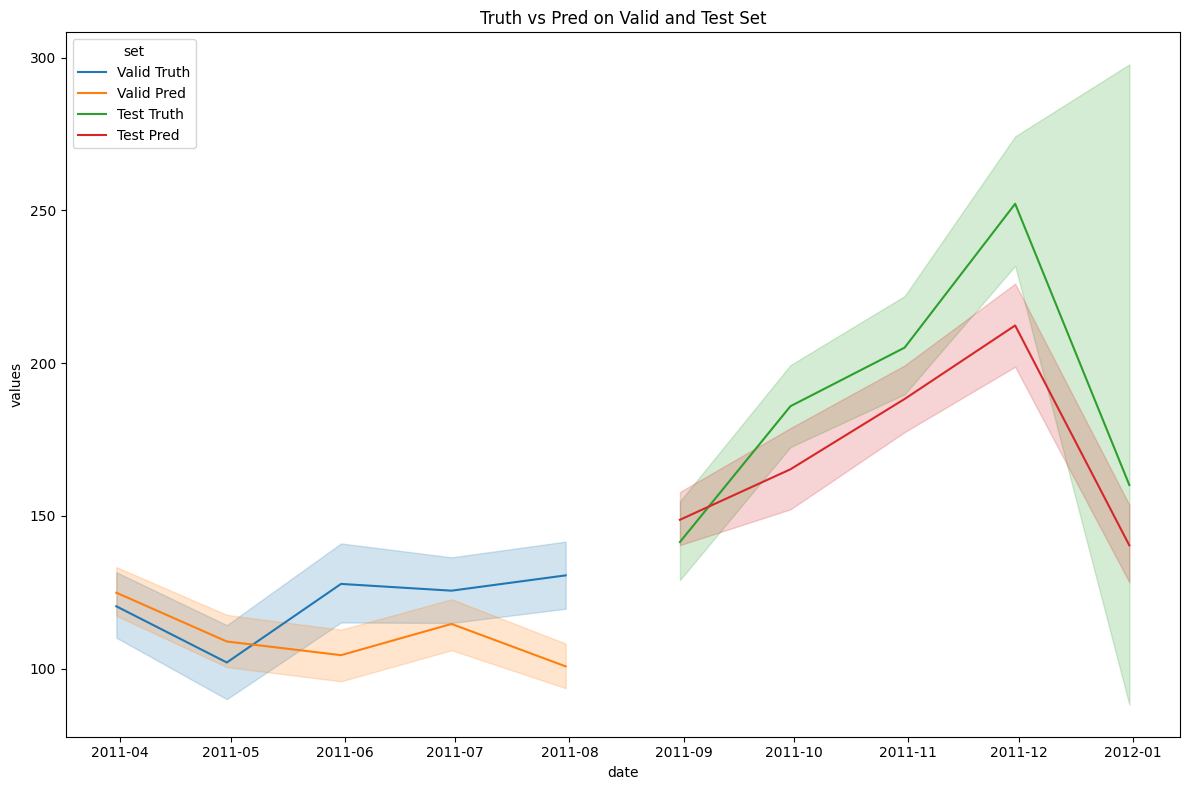

In [63]:
valid_df = pd.concat([
    pd.DataFrame({
        "date": valid.order_date,
        "values": y_valid.values,
        "set": "Valid Truth"
    }),
    pd.DataFrame({
        "date": valid.order_date,
        "values": y_pred_valid,
        "set": "Valid Pred"
    }),
    pd.DataFrame({
        "date": test.order_date,
        "values": y_test.values,
        "set": "Test Truth"
    }),
    pd.DataFrame({
        "date": test.order_date,
        "values": y_pred_test,
        "set": "Test Pred"
    })
])

plt.figure(figsize=(12, 8))

sns.lineplot(
    data=valid_df,
    x="date",
    y="values",
    hue="set"
)

plt.title("Truth vs Pred on Valid and Test Set")
plt.tight_layout()
plt.show()


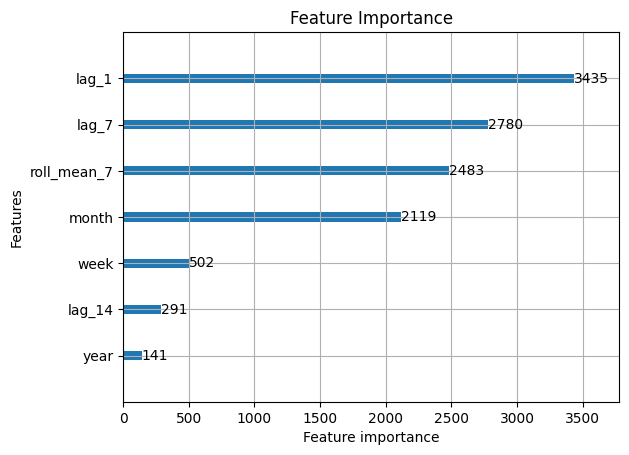

In [64]:
# untuk kepentingan explainability model
lgb.plot_importance(model, max_num_features=15)
plt.title("Feature Importance")
plt.show()


# 7. Forecasting

In [65]:
def recursive_forecast(df, model, horizon=6):
    future = df.copy()

    lags = [1, 7, 14, 30]
    rolls = [7, 30]
    features = ["month", "week", "year", "lag_1", "lag_7", "lag_14", "lag_30",
    "roll_mean_7", "roll_mean_30"]

    last_date = future["order_date"].max()

    forecasts = []

    for i in range(1, horizon+1):
        next_date = last_date + pd.DateOffset(months=i)

        temp = future.groupby("product_id").tail(1).copy()

        temp["order_date"] = next_date
        temp["month"] = next_date.month
        temp["week"] = next_date.isocalendar().week
        temp["year"] = next_date.year

        for lag in lags:
            temp[f"lag_{lag}"] = future.groupby("product_id")["quantity"] \
                .shift(lag)

        for r in rolls:
            temp[f"roll_mean_{r}"] = future.groupby("product_id")["quantity"] \
                .shift(1).rolling(r).mean()

        temp = temp.fillna(0)

        temp["quantity"] = model.predict(temp[features])

        forecasts.append(temp[["product_id", "order_date", "quantity"]])

        future = pd.concat([future, temp])
        future = future.reset_index(drop=True)

    return forecasts

In [66]:
forecast_6m = recursive_forecast(dataset_monthly, model, horizon=6)

In [67]:
stockup = pd.concat(forecast_6m).groupby("product_id")["quantity"].sum().reset_index() \
    .sort_values("quantity", ascending=False)

stockup.head(10)

,product_id,quantity
1441,22197,11510.417703
4408,85184D,10694.951503
4285,85099B,8204.082202
4296,85110,7684.886032
2283,23084,7223.107159
3554,84077,6151.424854
617,21212,6015.492232
2395,23201,5254.446808
4313,85123A,4876.121998
1334,22086,4765.550949


# 8. Artifacts Serialization

In [68]:
joblib.dump(model, "../model/model.pkl")

['../model/model.pkl']

In [69]:
joblib.dump(train, "../data/interim/train_data.pkl")
joblib.dump(valid, "../data/interim/valid_data.pkl")
joblib.dump(test, "../data/interim/test_data.pkl")

['../data/interim/test_data.pkl']

In [70]:
joblib.dump(X_train, "../data/processed/X_train.pkl")
joblib.dump(y_train, "../data/processed/y_train.pkl")
joblib.dump(X_valid, "../data/processed/X_valid.pkl")
joblib.dump(y_valid, "../data/processed/y_valid.pkl")
joblib.dump(X_test, "../data/processed/X_test.pkl")
joblib.dump(y_test, "../data/processed/y_test.pkl")

['../data/processed/y_test.pkl']

# 9. Potential Optimization